# Description

Ce classeur décrit les opérations effectuées sur les données issues du velib afin de réaliser une prédiction sur la disponibilité future, et illustre les résultats obtenus.

# Mise en place du classeur

## Importation des bibliothèques

In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import time
import random
import pickle
import sklearn as skl
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_error

#Scripts python en local:
import datasets as dst
import conf as cf

## Lecture des données 

In [2]:
def preProcessDataframe(df: object) -> object:
    dfret = df.dropna(subset = [
        "station_id", 
        "lat", 
        "lon", 
        "occupation_prct", 
        "occupation_class"
    ])
    
    return dfret

In [3]:
# path="C:/Users/Olivier/data/projet_julien/MeteoVelib/data/datasets/"
DF0 = preProcessDataframe(dst.getDataset("2023_03_17"))
DF1 = preProcessDataframe(dst.getDataset("2023_03_18"))
DF2 = preProcessDataframe(dst.getDataset("2023_03_19"))
DF3 = preProcessDataframe(dst.getDataset("2023_03_20"))
DF4 = preProcessDataframe(dst.getDataset("2023_03_21"))
DF5 = preProcessDataframe(dst.getDataset("2023_03_22"))
DF6 = preProcessDataframe(dst.getDataset("2023_03_23"))
DF7 = preProcessDataframe(dst.getDataset("2023_03_24"))
DF8 = preProcessDataframe(dst.getDataset("2023_03_25"))
DF9 = preProcessDataframe(dst.getDataset("2023_03_26"))
DF10 = preProcessDataframe(dst.getDataset("2023_03_27"))
DF11 = preProcessDataframe(dst.getDataset("2023_03_28"))
DF12 = preProcessDataframe(dst.getDataset("2023_03_29"))
DF13 = preProcessDataframe(dst.getDataset("2023_03_30"))

In [5]:
#Caracteristiques permanentes des stations
station_info=pd.read_json('F:/work/download/stations_info.json').data[0]
station_list=list(set(DF0.station_id))

In [315]:
station_list_100=random.sample(station_list, 100)

## Fonctions génériques sur les données

In [4]:
#Obtention de toutes les données pour une station
def getDatasetStation(station_id: int) -> object:    
    return pd.concat([
        DF0[DF0["station_id"] == station_id],
        DF1[DF1["station_id"] == station_id],
        DF2[DF2["station_id"] == station_id],
        DF3[DF3["station_id"] == station_id],
        DF4[DF4["station_id"] == station_id],
        DF5[DF5["station_id"] == station_id],
        DF6[DF6["station_id"] == station_id],
        DF7[DF7["station_id"] == station_id],
        DF8[DF8["station_id"] == station_id],
        DF9[DF9["station_id"] == station_id],
        DF10[DF10["station_id"] == station_id],
        DF11[DF11["station_id"] == station_id],
        DF12[DF12["station_id"] == station_id],
        DF13[DF13["station_id"] == station_id],
    ])

#Obtention de toutes les données pour toutes les stations
def getDatasetAll() -> object:    
    return pd.concat([
        DF0, DF1, DF2, DF3, DF4, DF5, DF6, DF7,
        DF8, DF9, DF10, DF11, DF12, DF13, 
    ])


In [231]:
def testRegressor(df: object, feat : list, target: list, model_type=None,
                  horizon :int = 0, plot_range :int = None, no_features=0, last_week=None) -> None:

    if not last_week is None:
        df_last=df.iloc[-horizon:,:]
        df_last['time']=df_last['time']-datetime.timedelta(days = 7)
        df_last=pd.merge_asof(left=df_last.sort_values('time'), right=df[['time', 'occupation_prct']].sort_values('time'), 
                             on='time', suffixes=('_old', ''), direction='nearest')
        df_last['time']=df_last['time']+datetime.timedelta(days = 7)
        last_week=df_last.set_index("time")
        last_week=last_week[target]
    
    
    dfbis = df.set_index("time")

    x_train, y_train, x_test, y_test, id_test=get_train_test(dfbis, feat, target, horizon)

    #Model training
    if model_type == 'forest' :
        model = RandomForestRegressor(random_state=0)
        model.fit(x_train, y_train.values.ravel())
    else :
        model = GradientBoostingRegressor(random_state=0)
        model.fit(x_train, y_train.values.ravel())

        
    #Prediction
    y_pred = model.predict(x_test)

    
    #
    if plot_range is None :
        plot_station_pred(y_test, y_pred, model, no_features=no_features, last_week=last_week)
    else :
        plot_station_pred(y_test.iloc[-plot_range:-1,:], y_pred[-plot_range:-1], model, no_features=no_features, last_week=last_week)


    mae = np.round(mean_absolute_error(y_test, y_pred), 3)
    return mae

In [89]:
def testClassifier(df: object, feat : list, target: list, model_type=None,
                  horizon :int = 0, plot_range :int = None, no_features=0) -> None:
    
    dfbis = df.set_index("time")

    x_train, y_train, x_test, y_test, id_test=get_train_test(dfbis, feat, target, horizon)

    #Model training
    if model_type == 'forest' :
        model = RandomForestClassifier(random_state=0)
        model.fit(x_train, y_train.values.ravel())
    else :
        model = GradientBoostingClassifier(random_state=0)
        model.fit(x_train, y_train.values.ravel())

        
    #Prediction
    y_pred = model.predict(x_test)

    #
    if plot_range is None :
        plot_station_pred(y_test, y_pred, model, no_features=no_features)
    else :
        plot_station_pred(y_test.iloc[-plot_range:-1,:], y_pred[-plot_range:-1], model, no_features=no_features)

In [7]:
#Obtention des données de test et d'entrainement, selon qu'on prend les données d'entrainement de façon
# aléatore ou sur les derniers temps
def get_train_test(df: object, feat : list, target: list, horizon = 0) -> None:

    x = df[feat]
    y = df[target]
    
    id_test=df['station_id']
    
    if horizon:
        x_train, x_test = x.iloc[:-horizon,:], x.iloc[-horizon:,:]
        y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]
    else:
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

    x_train = x_train.sort_index()
    y_train = y_train.sort_index()
    x_test = x_test.sort_index()
    y_test = y_test.sort_index()

  
    return x_train, y_train, x_test, y_test, id_test
    

In [223]:
def plot_station_pred(y_test, y_pred, model, y_prev=None, no_features=0, last_week=None):

    mae = np.round(mean_absolute_error(y_test, y_pred), 3)

    #--------------------------------------------------------------
    #plot reality vs prediction for the last week of the dataset
    #--------------------------------------------------------------
    fig = plt.figure(figsize=(16,6))
    plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
    plt.plot(y_test, color='red')
    plt.plot(pd.Series(y_pred, index = y_test.index), color='green')
    if not last_week is None :
        plt.plot(last_week, color='blue')    
    
    plt.xlabel('Hour', fontsize = 16)
    plt.ylabel('Occupation Prct', fontsize = 16)
    if not last_week is None : 
        plt.legend(labels=['Real', 'Prediction', 'last week'], fontsize = 16)
    else :
        plt.legend(labels=['Real', 'Prediction'], fontsize = 16)
    plt.grid()
    plt.show()
    
    #--------------------------------------------------------------
    #Displays the feature importances of the model. 
    #--------------------------------------------------------------
    if no_features : 
        return
    
    #create a dataframe with the feature importances of the model
    df_importances = pd.DataFrame({
        'feature': model.feature_names_in_,
        'importance': model.feature_importances_
    }).sort_values(by='importance', ascending=False)
    
    #plot feature importances of the model
    plt.title('Variable Importances', fontsize=16)
    sns.barplot(x = df_importances.importance, y = df_importances.feature, orient='h')
    plt.show()


In [140]:
#Estime l'erreur absolue moyenne par station dans le dataframe df
def get_mae_global(df: object, feat : list, target: list, model_type=None,
                  horizon :int = 0, station_list_red=None) -> None:
    
    mae=[]
    if station_list_red is None :
        station_list_red=list(set(df.station_id))

    for station in station_list_red :
    
        dfbis = df[df.station_id == station].set_index("time")

        x_train, y_train, x_test, y_test, id_test=get_train_test(dfbis, feat, target, horizon)

        #Model training
        if model_type == 'forest' :
            model = RandomForestRegressor(random_state=0)
            model.fit(x_train, y_train.values.ravel())
        else :
            model = GradientBoostingRegressor(random_state=0)
            model.fit(x_train, y_train.values.ravel())


        #Prediction
        y_pred = model.predict(x_test)

        
        mae.append( np.round(mean_absolute_error(y_test, y_pred), 3) )
    return mae
    

# Description des données

Les données disponibles sont sous la forme de dataframe avec les champs suivants décrivant l'état de chaque station :
- station_id : l'identifiant de la station. Cet identifiant n'est pas visible par l'utilisateur, qui connait lui un "stationCode"
- num_bikes_available : le nombre de vélos disponibles
- num_bikes_available_mech : le nombre de vélos standard disponibles
- num_bikes_available_elec : le nombre de vélos électriques disponibles
- num_docks_available : le nombre d'emplacements pour vélos disponibles
- is_installed, is_returning, is_renting : booléens indiquant l'état de la station (installé, accepte de recevoir des vélos, propose des vélos)
- last_reported : date de la dernière mise à jour

A cela s'ajoute des champs décrivant les caracteristiques permanentes de la station disponibles dans un fichier séparé contenant :
- name : nom de la station compréhensible par l'utilisateur
- lat, lon : latitude et longitude
- capacity : Nombre d'emplacements disponibles pour la station

Nous avons rajouté les champs suivants :
- time : le temps au format datetime de la requète au site vélib pour connaitre l'état des stations
- year, month, day, hour, minute : chaque composante de time au format int
- weekday : le jour de la semaine, avec 0 pour le lundi jusqu'à 6 pour le dimanche
- weather, temperature, humidity, visibility, wind_speed, wind_deg, clouds : des données météorologiques, obtenues sur un site tiers

Enfin, nous avons créé deux champs qui constitueront les cibles possibles de notre algorrithme de machine learning
- occupation_prct : le pourcentage des emplacements occupés par un vélo
- occupation_class : des classes que nous avons choisi pour occupation_prct



# Choix des caractéristiques du modèle de machine learning

In [306]:
#Lecture des données : 
df=getDatasetAll()

Notre approche était de partir d'un modèle de machine learning similaire à ce que nous avons vu en cours, puis de le modifier au fur et à mesure en fonction de nos résultats. 

Cette section décrit les différents choix que nous avons effectué, et illustre pour chacun d'entre eux une comparaison entre notre approche finale et l'alternative, dans un cas où ce choix est significatif.

Les choix représentés ici sont :
 - classifieur ou régresseur ?
 - quel type de regresseur ou classifieur utiliser ?
 - entrainer le modèle sur toutes les stations ou une seule ?
 - quelles features utiliser ?
 

## Choix d'un classifieur ou d'un régresseur

L'objectif de notre étude est de pouvoir décrire la disponibilité des stations vélib à un temps donné. 
Nous voulions à l'origine que cette prédiction soit purement qualitative. En d'autres termes, pouvoir dire par exemple quelles stations seront presque vides et quelles stations ne le seront pas.
Utiliser un classifieur paraissait donc la solution logique.

Cependant, utiliser un régresseur pour avoir une valeur chiffrée sur le degré d'occupation précis d'une station nous donnait plus d'information sur les faiblesses de notre modèle. Mais la perte d'information due au regroupement par classe n'était pas compensé par un quelconque gain. Il nous a donc semblé préférable de travailler sur des regresseurs.

['Auguste Blanqui - Corvisart']
Prediction using a classifier:


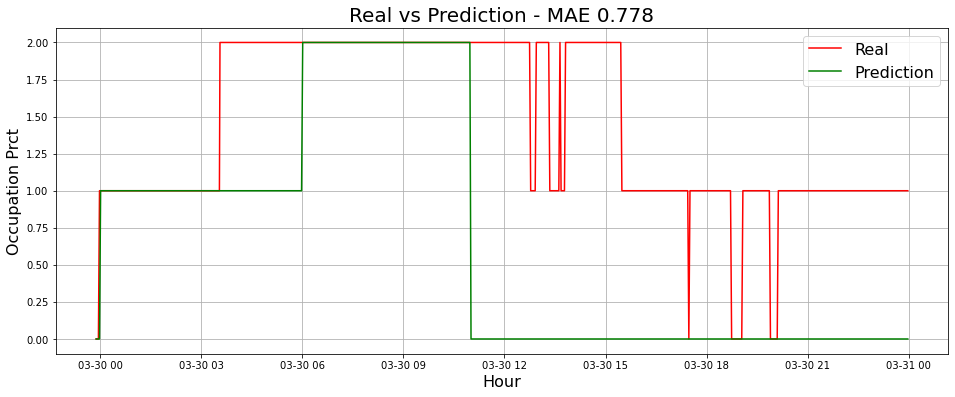

Prediction using a regressor:


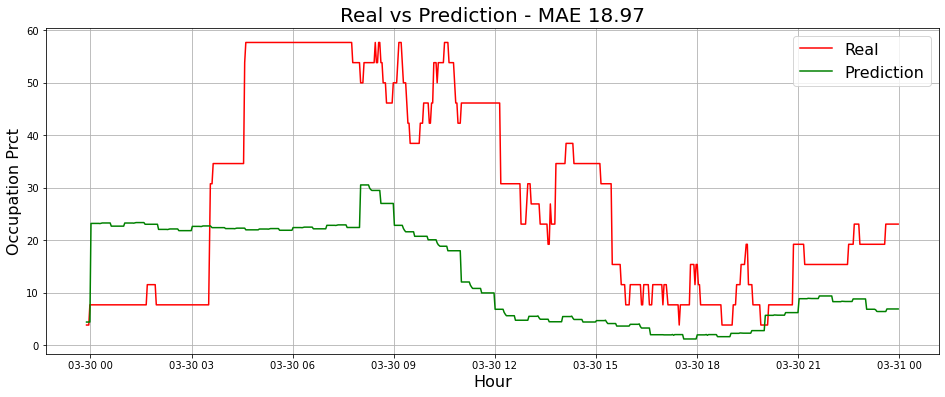

In [93]:
feat = ["station_id", "lon", "lat", "weekday", "day", "hour", "minute"]
target = ["occupation_prct"]
target_class=["occupation_class"]

for station in random.sample(station_list, 1):
# for station in random.sample([653147618], 1):
    
    foo=getDatasetStation(station)
    
    print(foo["name"].unique())
    
    print("Prediction using a classifier:")
    testClassifier(foo, feat, target_class, horizon=30*24, no_features=1)
    print("Prediction using a regressor:")
    testRegressor(foo, feat, target, horizon=30*24, no_features=1)
    

## Choix du modèle de régresseur

Il existe plusieurs modèles de régresseur disponibles dans sci-kit learn.
En plus du "random forest" vu en cours, le "gradient boosting" est couramment utilisé pour le type de problème étudié ici. La comparaison des deux montre que le "gradient boosting" est plus robuste et donne une erreur moyenne absolue légèrement plus faible, et nous avons donc utilisé uniquement celui-ci.

['Guichet - Jean Jaurès']
Prediction using a random forest:


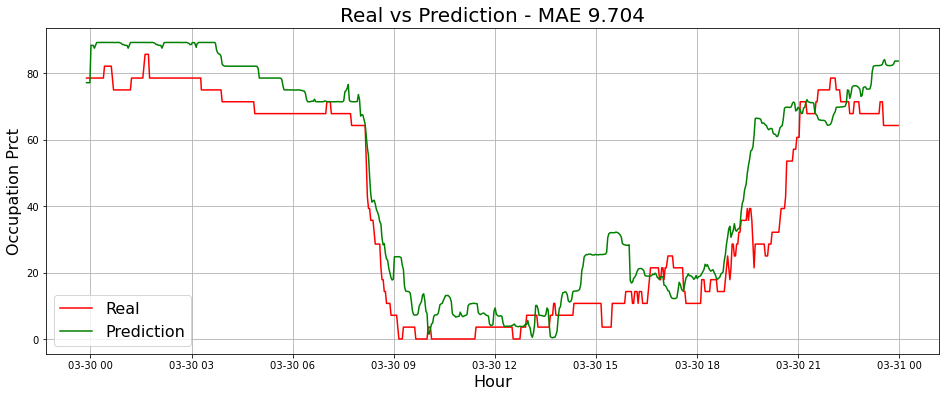

Prediction using a gradient boost:


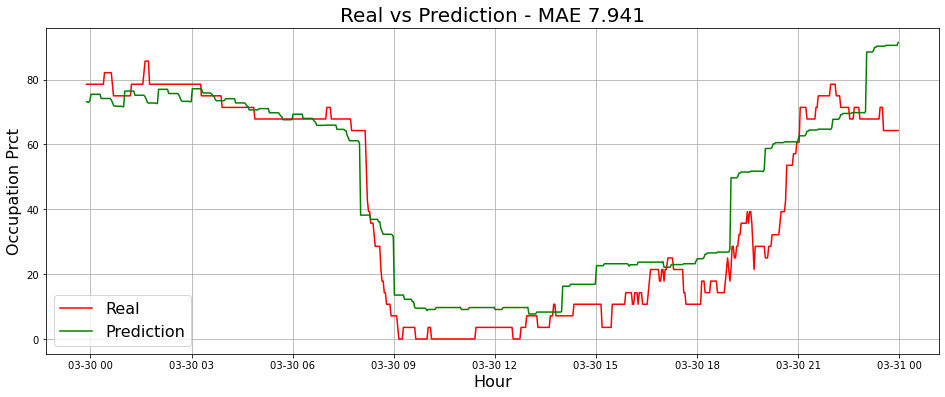

In [88]:
feat = ["station_id", "lon", "lat", "weekday", "day", "hour", "minute"]
target = ["occupation_prct"]
for station in random.sample(station_list, 1):
# for station in random.sample([653147618], 1):
    
    foo=getDatasetStation(station)
    
    print(foo["name"].unique())
    
    print("Prediction using a random forest:")
    testRegressor(foo, feat, target, horizon=30*24, no_features=1, model_type='forest')
    print("Prediction using a gradient boost:")
    testRegressor(foo, feat, target, horizon=30*24, no_features=1)
    

In [ ]:
# mae_forest=get_mae_global(df, feat, target, horizon=horizon, model_type='forest')
# mae_gradient=get_mae_global(df, feat, target, horizon=horizon)

mae_forest=get_mae_global(df, feat, target, horizon=horizon, model_type='forest', station_list_red=station_list_100)
mae_gradient=get_mae_global(df, feat, target, horizon=horizon, station_list_red=station_list_100)

In [162]:
print(f"Error using a random forest: {np.mean(mae_forest)}")
print(f"Error using a gradient boosting: {np.mean(mae_gradient)}")

Error using a random forest: 14.546980000000001
Error using a gradient boosting: 13.478000000000002


## Choix des périodes d'entrainement et de test

Nos premiers essais prenaient des données d'entrainement et de test aléatoirement parmi les données disponibles. Cela améliorait artificiellement les résultats, car le modèle utilisait les valeurs à un temps proche sans faire de réelle prédiction.

La période de test doit être après la période d'entrainement lorsque l'on cherche à faire une prédiction sur une série temporelle.


['Emile Reynaud - Porte de la Villette ']
Prediction using random points:


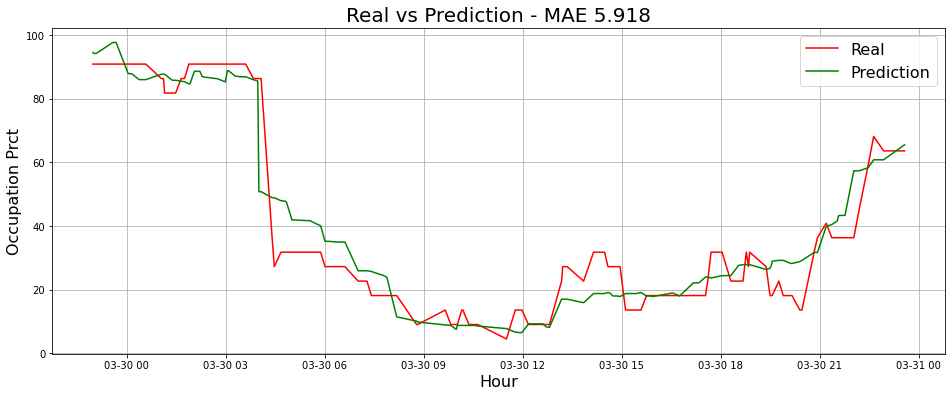

Prediction using points outside the training period:


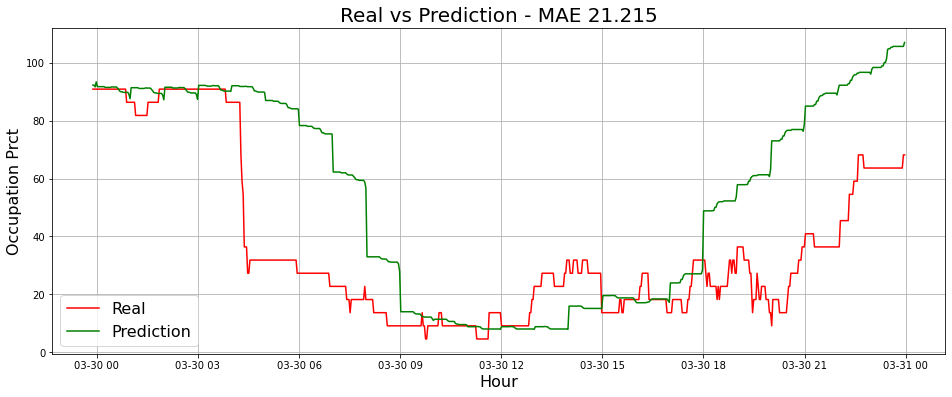

In [85]:
feat = ["station_id", "lon", "lat", "weekday", "day", "hour", "minute"]
target = ["occupation_prct"]
for station in random.sample(station_list, 1):
    
    foo=getDatasetStation(station)
    
    print(foo["name"].unique())
    
    print("Prediction using random points:")
    testRegressor(foo, feat, target, plot_range=6*24, no_features=1)
    print("Prediction using points outside the training period:")
    testRegressor(foo, feat, target, horizon=30*24, no_features=1)
    
    

## Utilisation de toutes les stations ou une seule

Il serait meilleur a priori d'utiliser toutes les stations dans un seul modèle afin d'avoir plus d'éléments sur lesquels le modèle puisse s'appuyer. Nous esperions également que le comportement des stations voisines puisse moduler le comportement observé à une station donnée. 

Cependant, les premiers résultats que nous avons obtenu montraient que les features de position avaient un poids démesurément important. Nous nous sommes donc limités à une seule station par modèle très tôt dans le projet.


Utiliser une seule station à la fois rend cependant les features constantes pour une station (l'identifiant de la station, sa latitude, sa longitude ou son altitude) sans effets.

In [76]:
horizon=30*24
no_features=0
feat = ["station_id", "lon", "lat", "weekday", "day", "hour", "minute"]
target = ["occupation_prct"]

In [70]:
#Training a model on every station and every time is too demanding for my computer, so I will
# use two similar days for the training and the testing for this section
x_train_all = DF2[feat].sort_index()
y_train_all = DF2[target].sort_index()
model = GradientBoostingRegressor(random_state=0)
model.fit(x_train_all, y_train_all.values.ravel())


GradientBoostingRegressor(random_state=0)

['Gabrielle Josserand - Edouard Vaillant']
Prediction after training one model on every station:


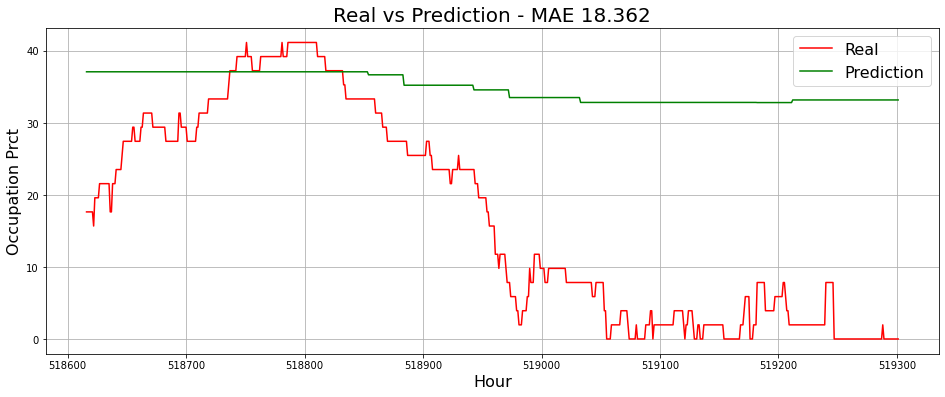

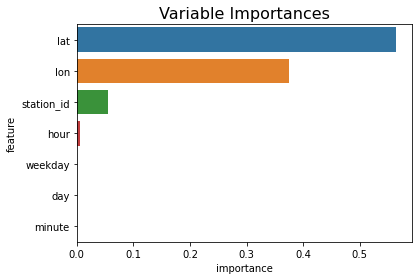

Prediction after training one model per station:


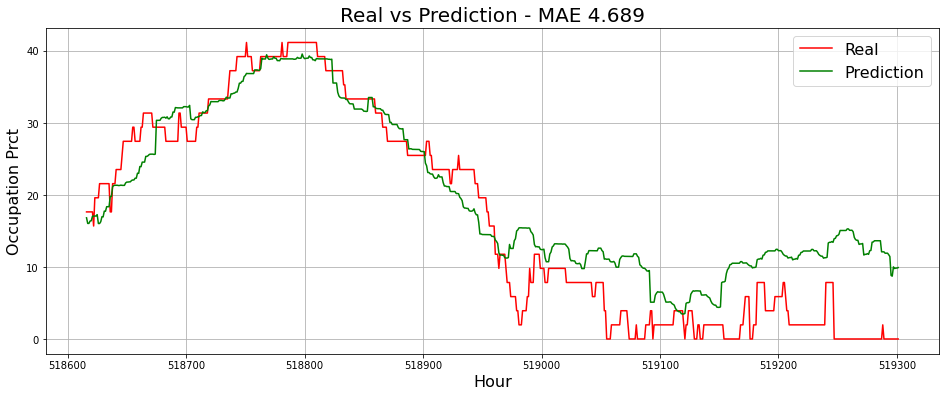

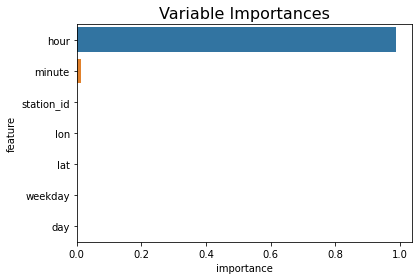

In [79]:
for station in random.sample(station_list, 1):

    ####################
    #Training for one station
    ####################    

    df_train=DF2[DF2.station_id == station]
    
    x_train_station = df_train[feat].sort_index()
    y_train_station = df_train[target].sort_index()

    model_station = GradientBoostingRegressor(random_state=0)
    model_station.fit(x_train_station, y_train_station.values.ravel())
    
    ####################
    #Prediction
    ####################
    
    df_test = DF9
    df_test = df_test[df_test.station_id == station]
    
    x_test = df_test[feat].sort_index()
    y_test = df_test[target].sort_index()

    
    #Prediction
    y_pred_all = model.predict(x_test)
    y_pred_station = model_station.predict(x_test)

    
    print(foo["name"].unique())
    
    print("Prediction after training one model on every station:")
    plot_station_pred(y_test, y_pred_all, model, no_features=no_features)

    print("Prediction after training one model per station:")
    plot_station_pred(y_test, y_pred_station, model_station, no_features=no_features)



## Choix des features

L'essentiel de notre étude a utilisé des données temporelles uniquement. Les autres données disponibles étaient fixées pour une station données donc ne pouvaient pas être traitées lorsque l'on se limitait à une seule station à la fois.

Il y a une forte périodicité des données d'une semaine sur l'autre, donc cela suffit souvent à avoir une prédiction approximative. Nous avons donc cherché quelles données pourraient être utilisées pour moduler ce cycle hebdomadaire, et en prédire les écarts. Les données météorologiques étaient une piste possible. 

Inclure les données météo à pour l'instant peu d'impact. Cela améliore parfois nos résultats mais l'erreur moyenne sur toutes les stations est légèrement plus élevée. Il faut cependant garder en tête que notre modèle d'entrainement ne s'étend que sur 2 semaines, ce qui n'est pas assez. Nous nous attendons à de meilleures corrections avec plus de données.

Nous avons aussi inclus les périodes de vacances ou le déroulement d'une grève dans les features, mais ce point aussi aura besoin de plus de données. 

["Place de l'Édit de Nantes"]
Prediction using only time variables:


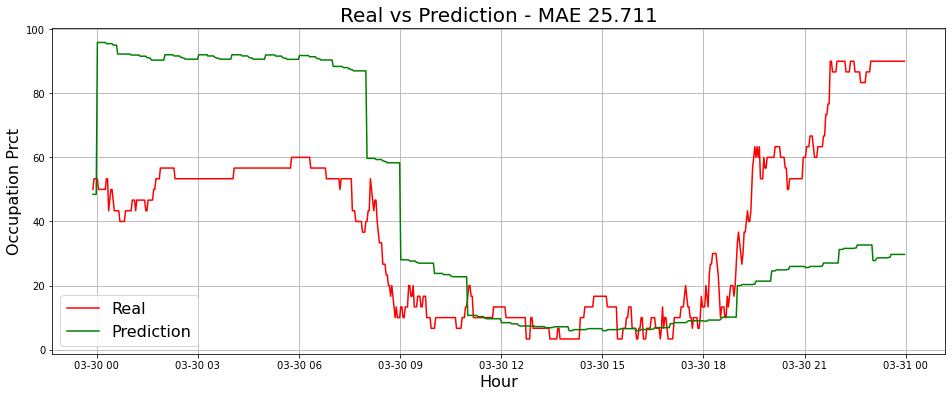

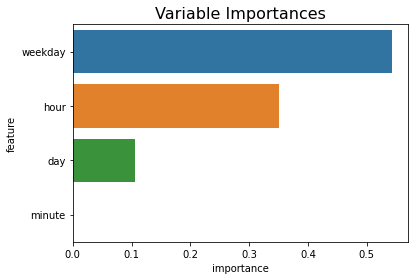

Prediction using time and meteo variables:


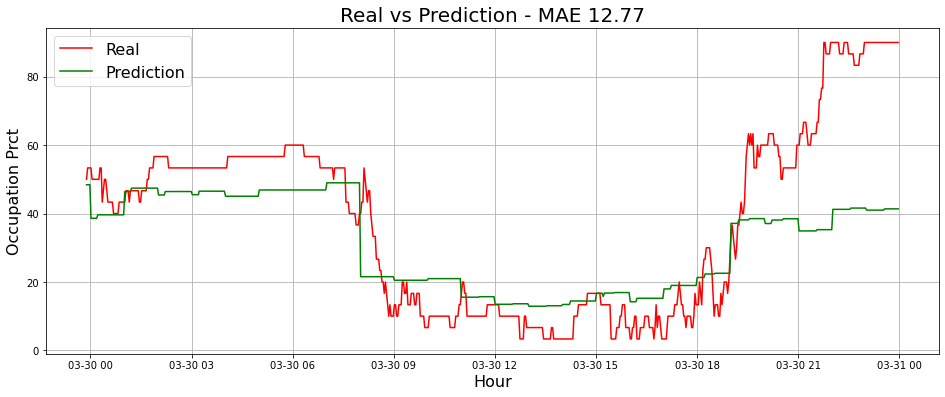

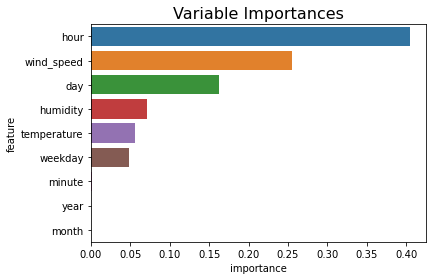

In [157]:
feat_base = ["weekday", "day", "hour", "minute"]
feat_all = ["temperature", "humidity", "wind_speed", "weekday", "year", "month", "day", "hour", "minute"]
horizon=30*24
no_features=0

target = ["occupation_prct"]
for station in random.sample(station_list, 1):
    
    foo=getDatasetStation(station)
    
    print(foo["name"].unique())
    
    print("Prediction using only time variables:")
    testRegressor(foo, feat_base, target, horizon=horizon, no_features=no_features)
    print("Prediction using time and meteo variables:")
    testRegressor(foo, feat_all, target, horizon=30*24, no_features=0)
    
    

In [158]:
# mae_base=get_mae_global(df, feat_base, target, horizon=horizon)
# mae_all=get_mae_global(df, feat_all , target, horizon=horizon)

mae_base=get_mae_global(df, feat_base, target, horizon=horizon, station_list_red=station_list_100)
mae_all=get_mae_global(df, feat_all , target, horizon=horizon, station_list_red=station_list_100)

print(f"Error using only time variables: {np.mean(mae_base)}")
print(f"Error using time and meteo variables: {np.mean(mae_all)}")

Error using only time variables: 13.46757
Error using time and meteo variables: 13.88


# Version finale de l'algorithme

## Description

Notre approche utilise un régresseur de type 'gradient boosting regressor" entrainé sur une station à la fois. La version en ligne laisse la dernière semaine de données de coté comme données de test.
Les features sont le temps et la météo.

['Bordier - Félix Faure']
Prediction using only time variables:


C:\Users\Olivier\AppData\Local\Temp\ipykernel_11428\2225835059.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last['time']=df_last['time']-datetime.timedelta(days = 7)


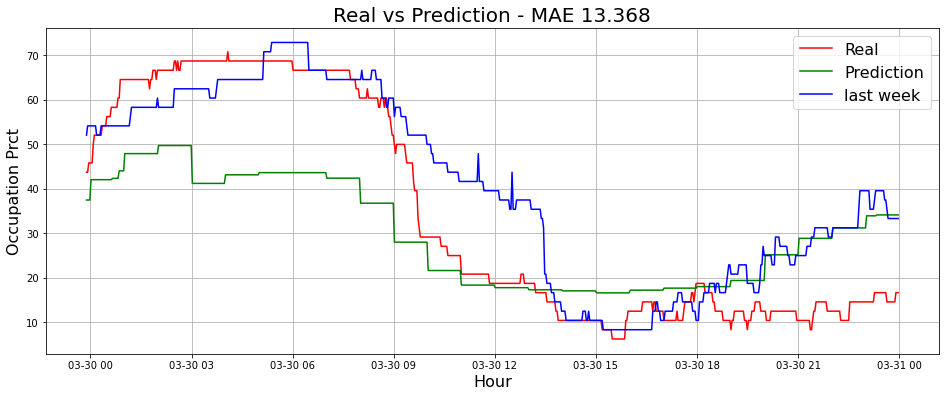

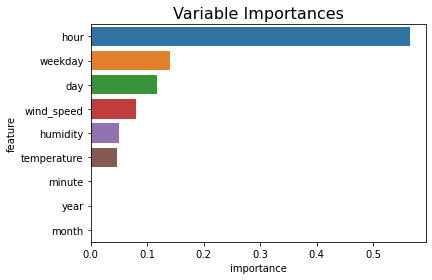

In [243]:
# feat = ["weekday", "day", "hour", "minute"]
feat = ["temperature", "humidity", "wind_speed", "weekday", "year", "month", "day", "hour", "minute"]
target = ["occupation_prct"]
horizon=30*24
no_features=0


# for station in random.sample(station_list, 1):
# 571923059
for station in random.sample([571923059], 1):
    
    foo=getDatasetStation(station)
    
    print(foo["name"].unique())
    
    print("Prediction using only time variables:")
    testRegressor(foo, feat, target, horizon=horizon, no_features=no_features, last_week=1)
    
    

## Effet de l'augmentation du nombre de données

Nous n'avons à l'heure actuelle que 2 semaines de données. Sachant que celles-ci suivent un cycle hebdomadaire, notre algorithme a encore trop peu de données pour pouvoir prendre en compte correctement les features présentes.

Cette section montre l'évolution que la hausse du nombre de données apporte à la prédiction. Nous prenons 3 classes de données : 
- 13 jours de données d'entrainement, soit toutes les données disponibles
- 7 jours, soit assez pour avoir accès au vendredi précédent et donc à la cyclicité hebdomadaire
- 6 jours, soit trop peu pour avoir accès au vendredi précédent


On trace pour 4 stations aléatoires les prédictions pour chaque classe de données, et on peut voir que les progrès ne sont pas systématiques avec la hausse du nombre de données. 
La MAE sur une centaine de stations, calculée plus bas, est même meilleure avec 7 jours qu'avec 13, sans doute parce que les valeurs de la semaine précédente sont en plus faible proportion.

Pyrénées - Emmery , id: 102324803


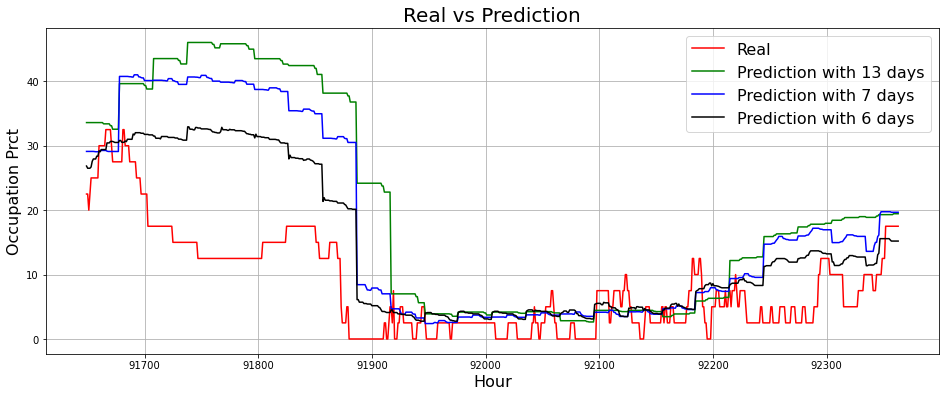

Manin - Secrétan , id: 125370566


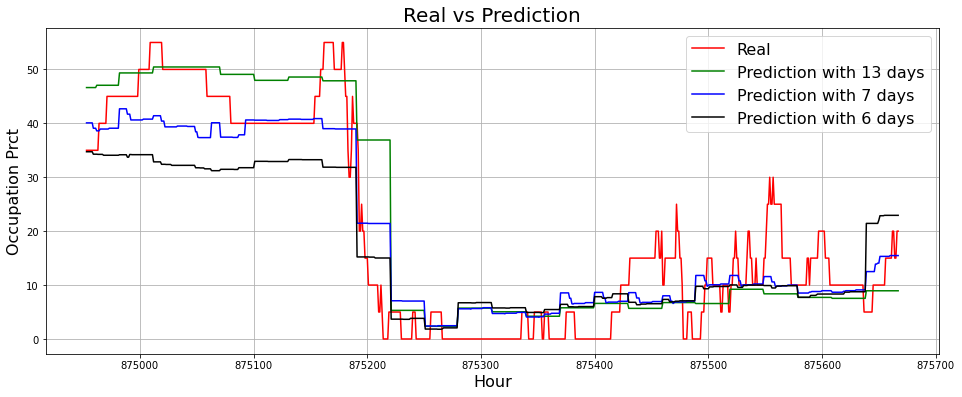

Moulin de la Pointe , id: 82436057


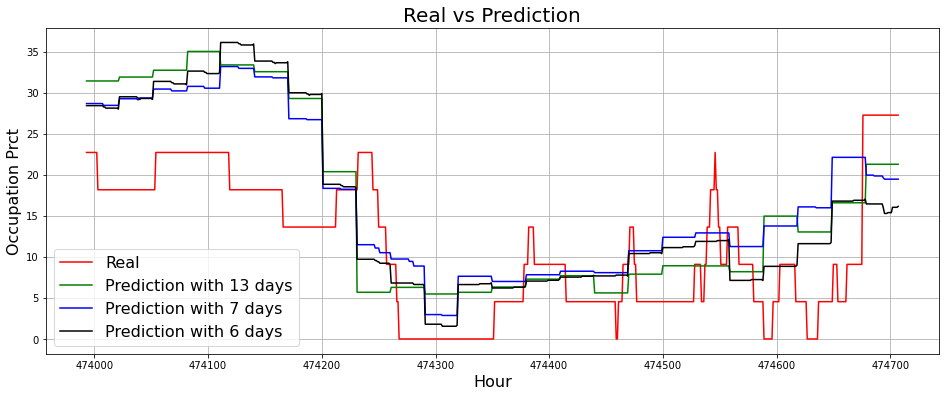

Aboukir - Alexandrie , id: 15290700


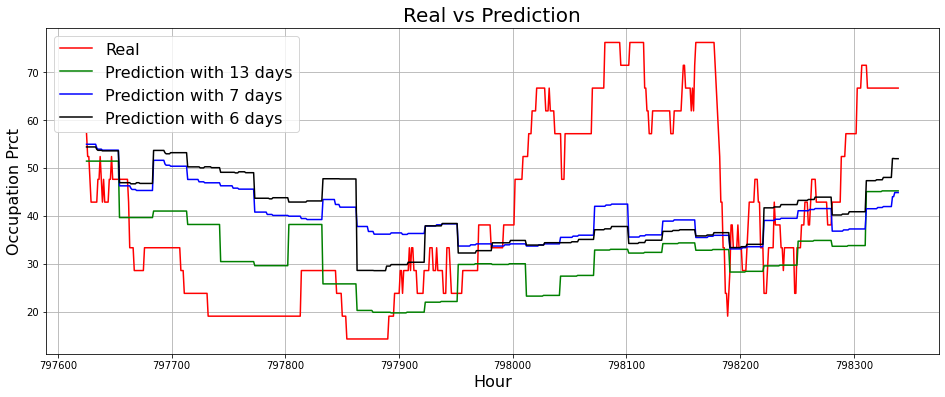

In [281]:
feat = ["temperature", "humidity", "wind_speed", "weekday", "year", "month", "day", "hour", "minute"]
target = ["occupation_prct"]
horizon=30*24-5
no_features=0


for station in random.sample(station_list, 4):
    

    df_14d=getDatasetStation(station)
    df_7d=df_14d[df_14d['day'] >= 23 ]
    df_6d=df_14d[df_14d['day'] >= 24 ]
    
    print(f"{df_14d['name'].unique()[0]} , id: {station}")
    
    x_train_14d, y_train_14d, x_test, y_test, id_test=get_train_test(df_14d, feat, target, horizon)
    x_train_7d, y_train_7d, _, _, _ =get_train_test(df_7d, feat, target, horizon)
    x_train_6d, y_train_6d, _, _, _ =get_train_test(df_6d, feat, target, horizon)
    

    model_14d = GradientBoostingRegressor(random_state=0)
    model_14d.fit(x_train_14d, y_train_14d.values.ravel())

    model_7d = GradientBoostingRegressor(random_state=0)
    model_7d.fit(x_train_7d, y_train_7d.values.ravel())
    
    model_6d = GradientBoostingRegressor(random_state=0)
    model_6d.fit(x_train_6d, y_train_6d.values.ravel())
    
    
    #Prediction
    y_pred_14d = model_14d.predict(x_test)
    y_pred_7d = model_7d.predict(x_test)
    y_pred_6d = model_6d.predict(x_test)
    
    #
    


    #--------------------------------------------------------------
    #plot reality vs prediction 
    #--------------------------------------------------------------
    fig = plt.figure(figsize=(16,6))
    plt.title(f'Real vs Prediction', fontsize=20)
    plt.plot(y_test, color='red')
    plt.plot(pd.Series(y_pred_14d, index = y_test.index), color='green')
    plt.plot(pd.Series(y_pred_7d, index = y_test.index), color='blue')
    plt.plot(pd.Series(y_pred_6d, index = y_test.index), color='black')
    
    plt.xlabel('Hour', fontsize = 16)
    plt.ylabel('Occupation Prct', fontsize = 16)
    plt.legend(labels=['Real', 'Prediction with 13 days', 
                       'Prediction with 7 days',
                       'Prediction with 6 days'], fontsize = 16)

    plt.grid()
    plt.show()
    

In [317]:
mae_14d=get_mae_global(df, feat, target, horizon=horizon, station_list_red=station_list_100)
mae_7d= get_mae_global(df[df['day'] >= 23 ], feat, target, horizon=horizon, station_list_red=station_list_100)
mae_6d= get_mae_global(df[df['day'] >= 24 ], feat, target, horizon=horizon, station_list_red=station_list_100)


In [318]:
np.mean(mae_14d),np.mean(mae_7d),np.mean(mae_6d)

(11.551590000000001, 11.26014, 12.022700000000002)

# Perspectives

Nous avons dû laisser de coté plusieurs pistes d'améliorations en raison de la courte durée du projet.
Celles-ci pourraient être étudiées plus tard pour améliorer les résultats, surtout une fois que plus de données seraient disponibles :
- nos modèles utilisent les valeurs par défaut
- chaque station est étudiée indépendamment : l'état des stations voisines devrait affecter une station
- il n'y a pas de prises en compte de l'aspect 'série temporelle' et de la continuité : la présence d'une déviation par rapport à la norme au moment de la prédiction devrait pouvoir être prise en compte comme une feature supplémentaire pour corriger les prédictions, au moins à court terme
- nous nous sommes limités au machine learning standard : une approche par deep learning pourrait apporter des résultats différents